## Exploratory Data Analysis for Object Detection

1. Importing essential Libraries

2. Understanding the Data

3. Data Preparation

4. Data Visualization

5. Data Cleaning 

### 1. Importing essential Liraries 

These are some of the libraries that are imported which are quite important to perform EDA for Object Detection :
- Commonly used libraries in python such as numpy, pandas, os, etc. 
- Visualization library such as matplotlib, PIL
- Deep learning frameworks such as tensorflow

In [13]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
import warnings

from tqdm.auto import tqdm
from PIL import Image, ImageDraw, ImageEnhance
warnings.filterwarnings("ignore")

### 2. Understanding the Data
Reading the data carefully is the most crucial step in EDA as all of the important information are extracted out from the raw data. \
It includes step such as :

- Reading the files
- Checking the size and shape of the data 
- Checking presence of duplicated data
- Checking presence of null values
- etc.

In [41]:
# Reading the files
train_dir = "../artifacts/train"
test_dir = "../artifacts/test"

labels = pd.read_csv("../artifacts/train.csv")
labels.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [16]:
# Checking the shape of data
print("Shape of the data about training labels : ", labels.shape)
print(f"There are {labels.shape[0]} rows and {labels.shape[1]} columns in the training labels data.")

Shape of the data about training labels :  (147793, 5)
There are 147793 rows and 5 columns in the training labels data.


In [18]:
print("The data has these columns namely : ", list(labels.columns))

The data has these columns namely :  ['image_id', 'width', 'height', 'bbox', 'source']


In [19]:
# Checking presence of duplicated data
print("No. of unique images : ", len(np.unique(labels["image_id"])))

No. of unique images :  3373


In [28]:
# Checking presence of null values
print("Null values count : ", labels["bbox"].isna().sum())

Null values count :  0


In [33]:
print("Minimum bboxes in one trainig image : ", labels["image_id"].value_counts().min())
print("Maximum bboxes in one trainig image : ", labels["image_id"].value_counts().max())

Minimum bboxes in one trainig image :  1
Maximum bboxes in one trainig image :  116


In [32]:
# Summary of data
print("Information about the data : ")
labels.info()

Information about the data : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


### 3. Data Preparation

- Since the `bbox` column of the data store values of the bounding boxes of a particular image it must be of float value but by default it is stored as object type, so it must be converted to float and also the bbox should be grouped for a particular `image_id`.

- Splitting the data into training and validation sets are also important for a model to learn and generalize the pattern of the wheat image data. Normally it is done as 80-20 split where 80% of data belongs to training set and 20% of data belongs to the validation set.

- Loading the image as pixels along with their bounding boxes should be done inorder to visualize the data and converting them to numpy arrays is useful for the model to interpret the data easily.

In [34]:
# Function for converting bbox into type float
def str_to_float(group):
    bboxes = group["bbox"].str.split(",", expand=True)
    bboxes[0] = bboxes[0].str.slice(start=1)
    bboxes[3] = bboxes[3].str.slice(stop=-1)
    return bboxes.values.astype(float)

new_labels = labels.groupby("image_id").apply(str_to_float)

In [35]:
# Lets see the first 10 bounding bboxes of an image 
image_id = "b6ab77fd7"
new_labels[image_id][:10]

array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       [834.,  95., 109., 107.],
       [ 26., 144., 124., 117.],
       [569., 382., 119., 111.],
       [ 52., 602.,  82.,  45.],
       [627., 302., 122.,  75.],
       [412., 367.,  68.,  82.],
       [953., 220.,  56., 103.]])

In [37]:
# Lets see the first 10 image ids
all_image_ids = new_labels.index
print(all_image_ids[:10])

Index(['00333207f', '005b0d8bb', '006a994f7', '00764ad5d', '00b5fefed',
       '00b70a919', '00e903abe', '00ea5e5ee', '010b216d4', '010c93b99'],
      dtype='object', name='image_id')


In [38]:
# Lets split the data into training data and validation data 
# The criteria is 80 % training and 20% validation data 

train_idx = int(round(0.8 * len(all_image_ids), 0))
train_data = new_labels[:train_idx]
validation_data = new_labels[train_idx:]

print("Length of training data : ", train_data.shape)
print("Length of validation data : ", validation_data.shape)

Length of training data :  (2698,)
Length of validation data :  (675,)


In [47]:
# Lets prepare the image and load it as numpy arrays to merge images and its labels
def load_image_as_pixels(image_id):
    image = Image.open(train_dir + "/" + image_id + ".jpg")
    image = image.resize((256, 256))
    return np.asarray(image) 

In [48]:
# From the image_id now we can have both the image pixels (helpful in plotting image) 
# and bbox coordinates (helpful in plotting the bbox in the image)

train_pixels = {}
train_labels = {}
                
for image_id in tqdm(train_data.index):
    train_pixels[image_id] = load_image_as_pixels(image_id)
    train_labels[image_id] = train_data[image_id].copy() / 4     # bacause we resized the image from 1024 to 256 so 1024 / 4 = 256     

100%|██████████| 2698/2698 [01:02<00:00, 43.19it/s]


In [49]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(validation_data.index):
    val_pixels[image_id] = load_image_as_pixels(image_id)
    val_labels[image_id] = validation_data[image_id].copy() / 4

100%|██████████| 675/675 [00:17<00:00, 37.84it/s]


### 4. Data Visualization
- Since we have loaded the images as pixels along with their bounding boxes as numpy arrays we can be able to visualize the data with the help of libraries such as `PIL` and `matplotlib`

In [56]:
# Lets visulaize the images and their labels

def plot_bboxes(image_id, bboxes, data=train_dir):
    image = Image.open(data + "/" + image_id + ".jpg")
    image = image.resize((256, 256)) 
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    return np.asarray(image) / 255

def draw_bbox(draw, bbox):
    x, y, w, h = bbox
    draw.rectangle([x, y, x+w, y+h], width=2, outline="red")
    draw.circle([(x+w/2) , (y+h/2) ], radius=1, width=2, outline="red")
    return

def plot_images_with_bboxes(image_ids, image_labels, data=train_dir):
    img_pixels = []
    for img_id in np.unique(image_ids):
        bboxes_of_img = image_labels[img_id]
        img_pixels.append(plot_bboxes(img_id, bboxes_of_img, data))

    n = len(image_ids)
    if n == 1:
        plt.imshow(img_pixels[0])
        return
        
    fig, axes = plt.subplots(1, n, figsize=(20*n, 20*n))
    for i, img_pixel in enumerate(img_pixels):
        axes[i].imshow(img_pixel)
    return

# Lets make a function to visualize some random images along with thier bboxes
def show_images(n):
    all_image_ids = list(new_labels.index.values)
    image_ids = random.sample(all_image_ids, k=n)
    image_pixels = []
    
    for img_id in image_ids:
        if img_id in train_labels:
            bboxes_of_img = train_labels[img_id]
        else:
            bboxes_of_img = val_labels[img_id]
        image_pixels.append(plot_bboxes(img_id, bboxes_of_img))
    
    fig, axes = plt.subplots(1, n, figsize=(20*n, 20*n))
    for i, img_pixel in enumerate(image_pixels):
        axes[i].imshow(img_pixel)

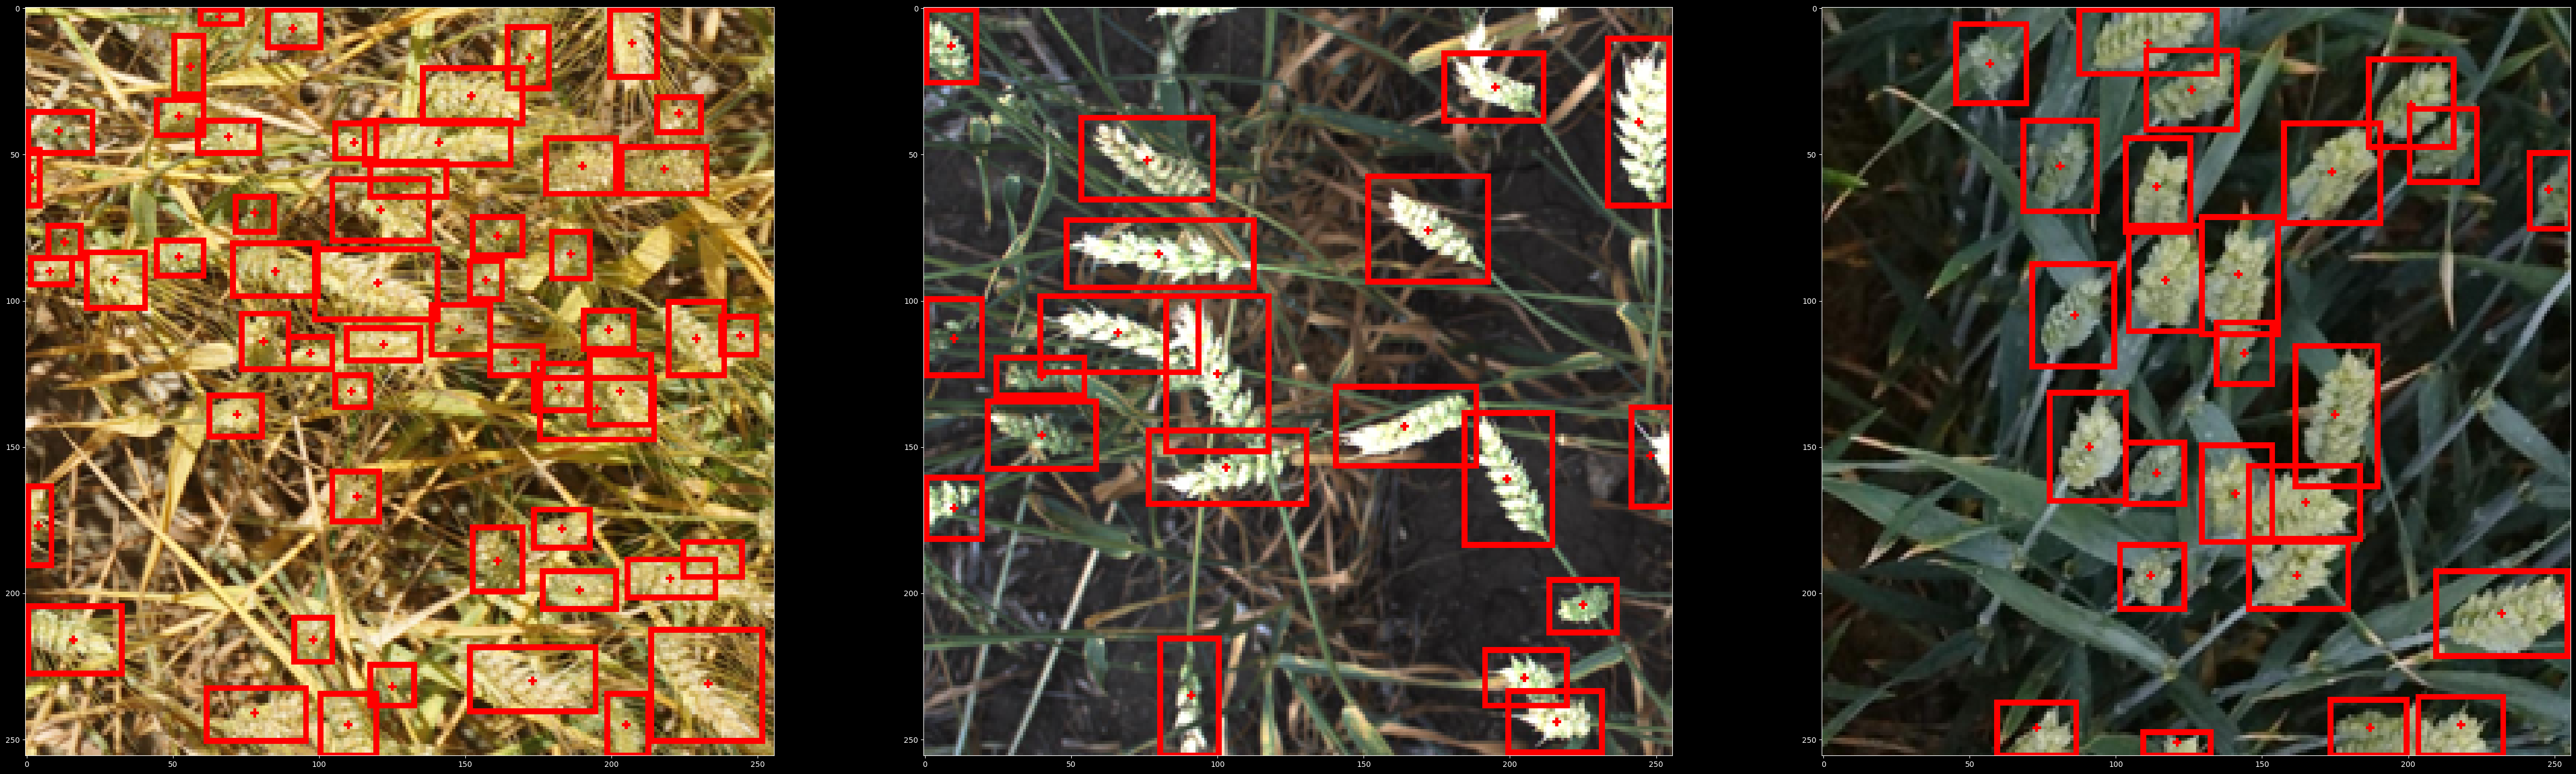

In [57]:
# Plot the examples from train_data
plot_images_with_bboxes(train_data.index[:3], train_labels)

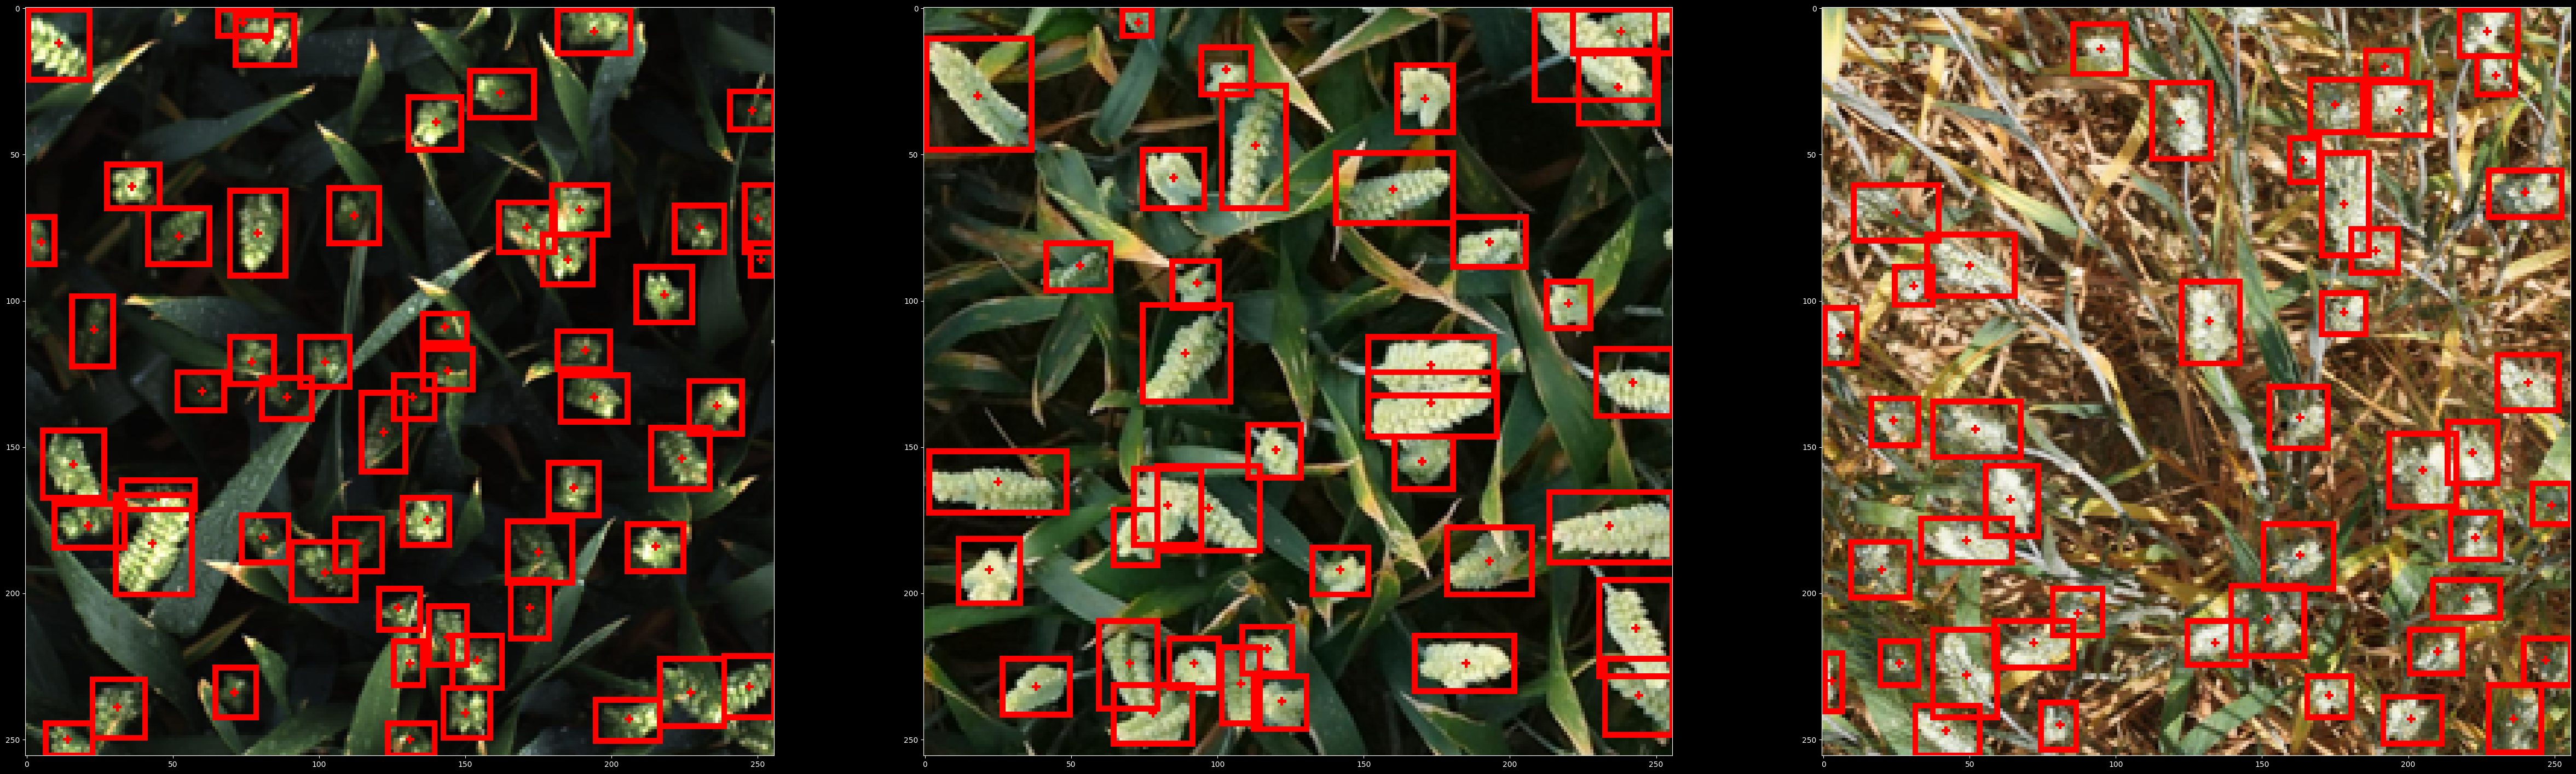

In [59]:
# Plot the examples from validataion_data
plot_images_with_bboxes(validation_data.index[:3], val_labels)

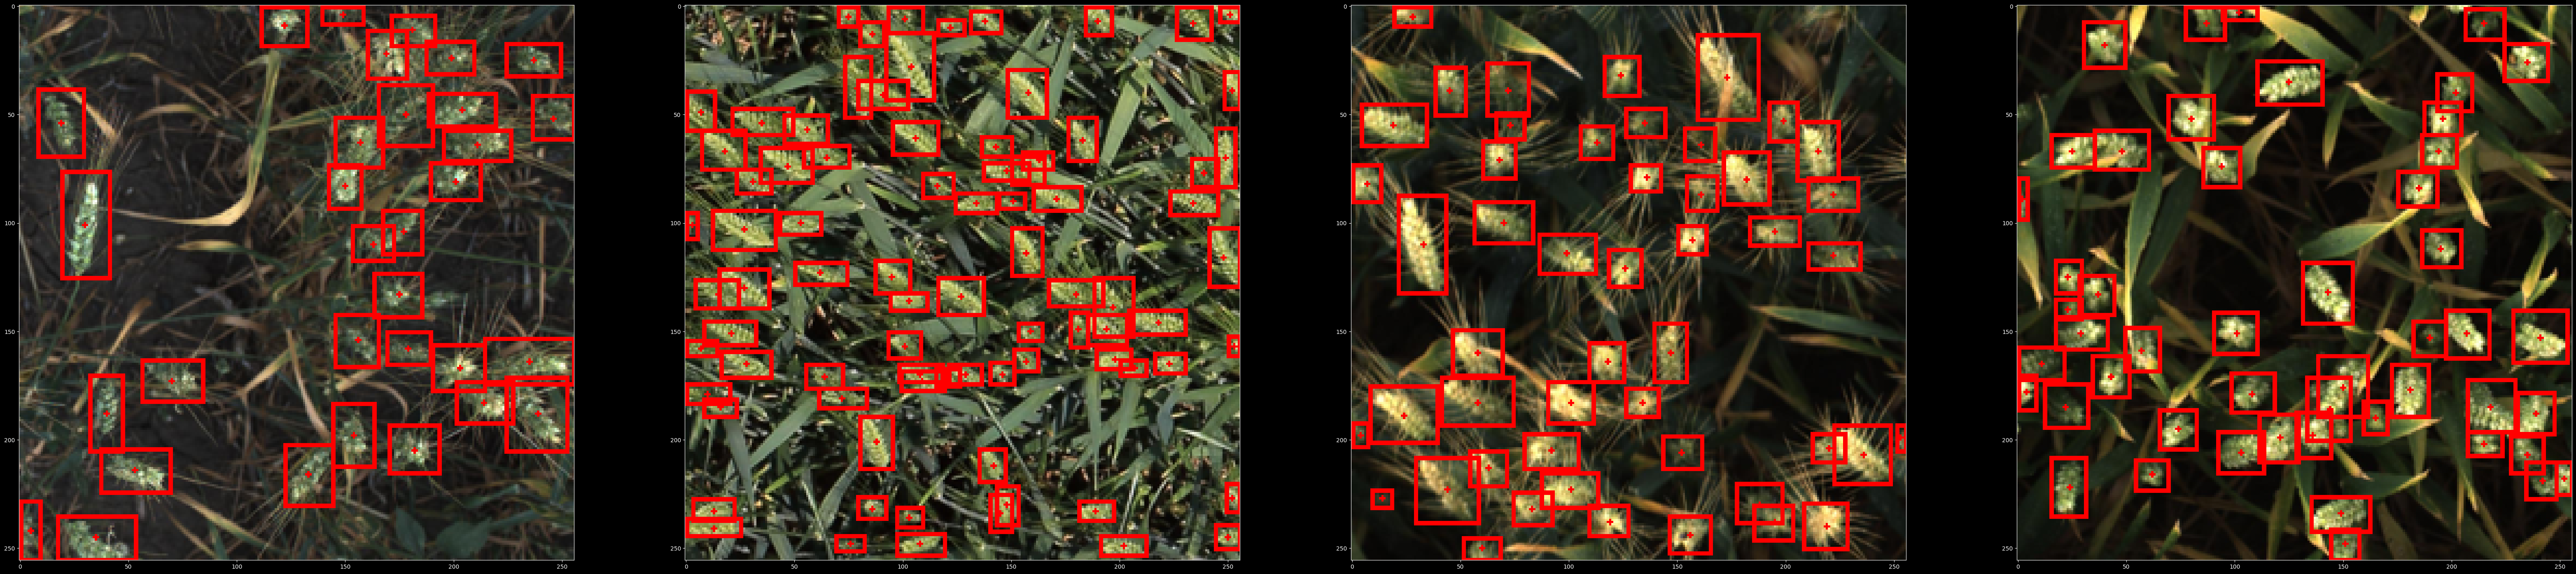

In [62]:
# Show some random images : This output changes each time you run it.
show_images(4)

### 5. Data Cleaning 

- As you can see some images have very tiny bounding boxes that are very hard to inference by any model and some are huge bounding boxes that are present along with the tiny ones, causing overlapping, in this case we need to apply non-max suppression to avoid the irrelevant tiny and huge bounding boxes.

- One more technique we can do is to first clean some images with extremely tiny bounding boxes like having an area of 10 or less.

- Also we cannot remove the huge bounding boxes because it may be possible that the image had only one bounding box or may be the image is a zoomed image. This doesn't mean that only tiny bounding boxes are irrelevant. Some examples of huge bboxes that are irrelevant are shown below.

- We can only remove the huge bounding boxes with the Non-Max Suppression Algorithm. Because it works over a submetric called Intersection Over Union or (IOU) which is covered in the prediction pipeline.

In [63]:
# Lets see the largest and smallest area bboxes in the entire dataset
all_image_ids = new_labels.index
min_area = float("inf")
max_area = float("-inf")

for ids in tqdm(all_image_ids):
    if ids in train_labels:
        for label in train_labels[ids]:
            min_area = min(min_area, label[2]*label[3])
            max_area = max(max_area, label[2]*label[3])
print("Largest area of bounding box in dataset : ", max_area)
print("Smallest area of bounding box in dataset : ", min_area)

100%|██████████| 3373/3373 [00:00<00:00, 18301.38it/s]

Largest area of bounding box in dataset :  33111.75
Smallest area of bounding box in dataset :  0.375


There are 4 huge bounding boxes found with the given threshold.


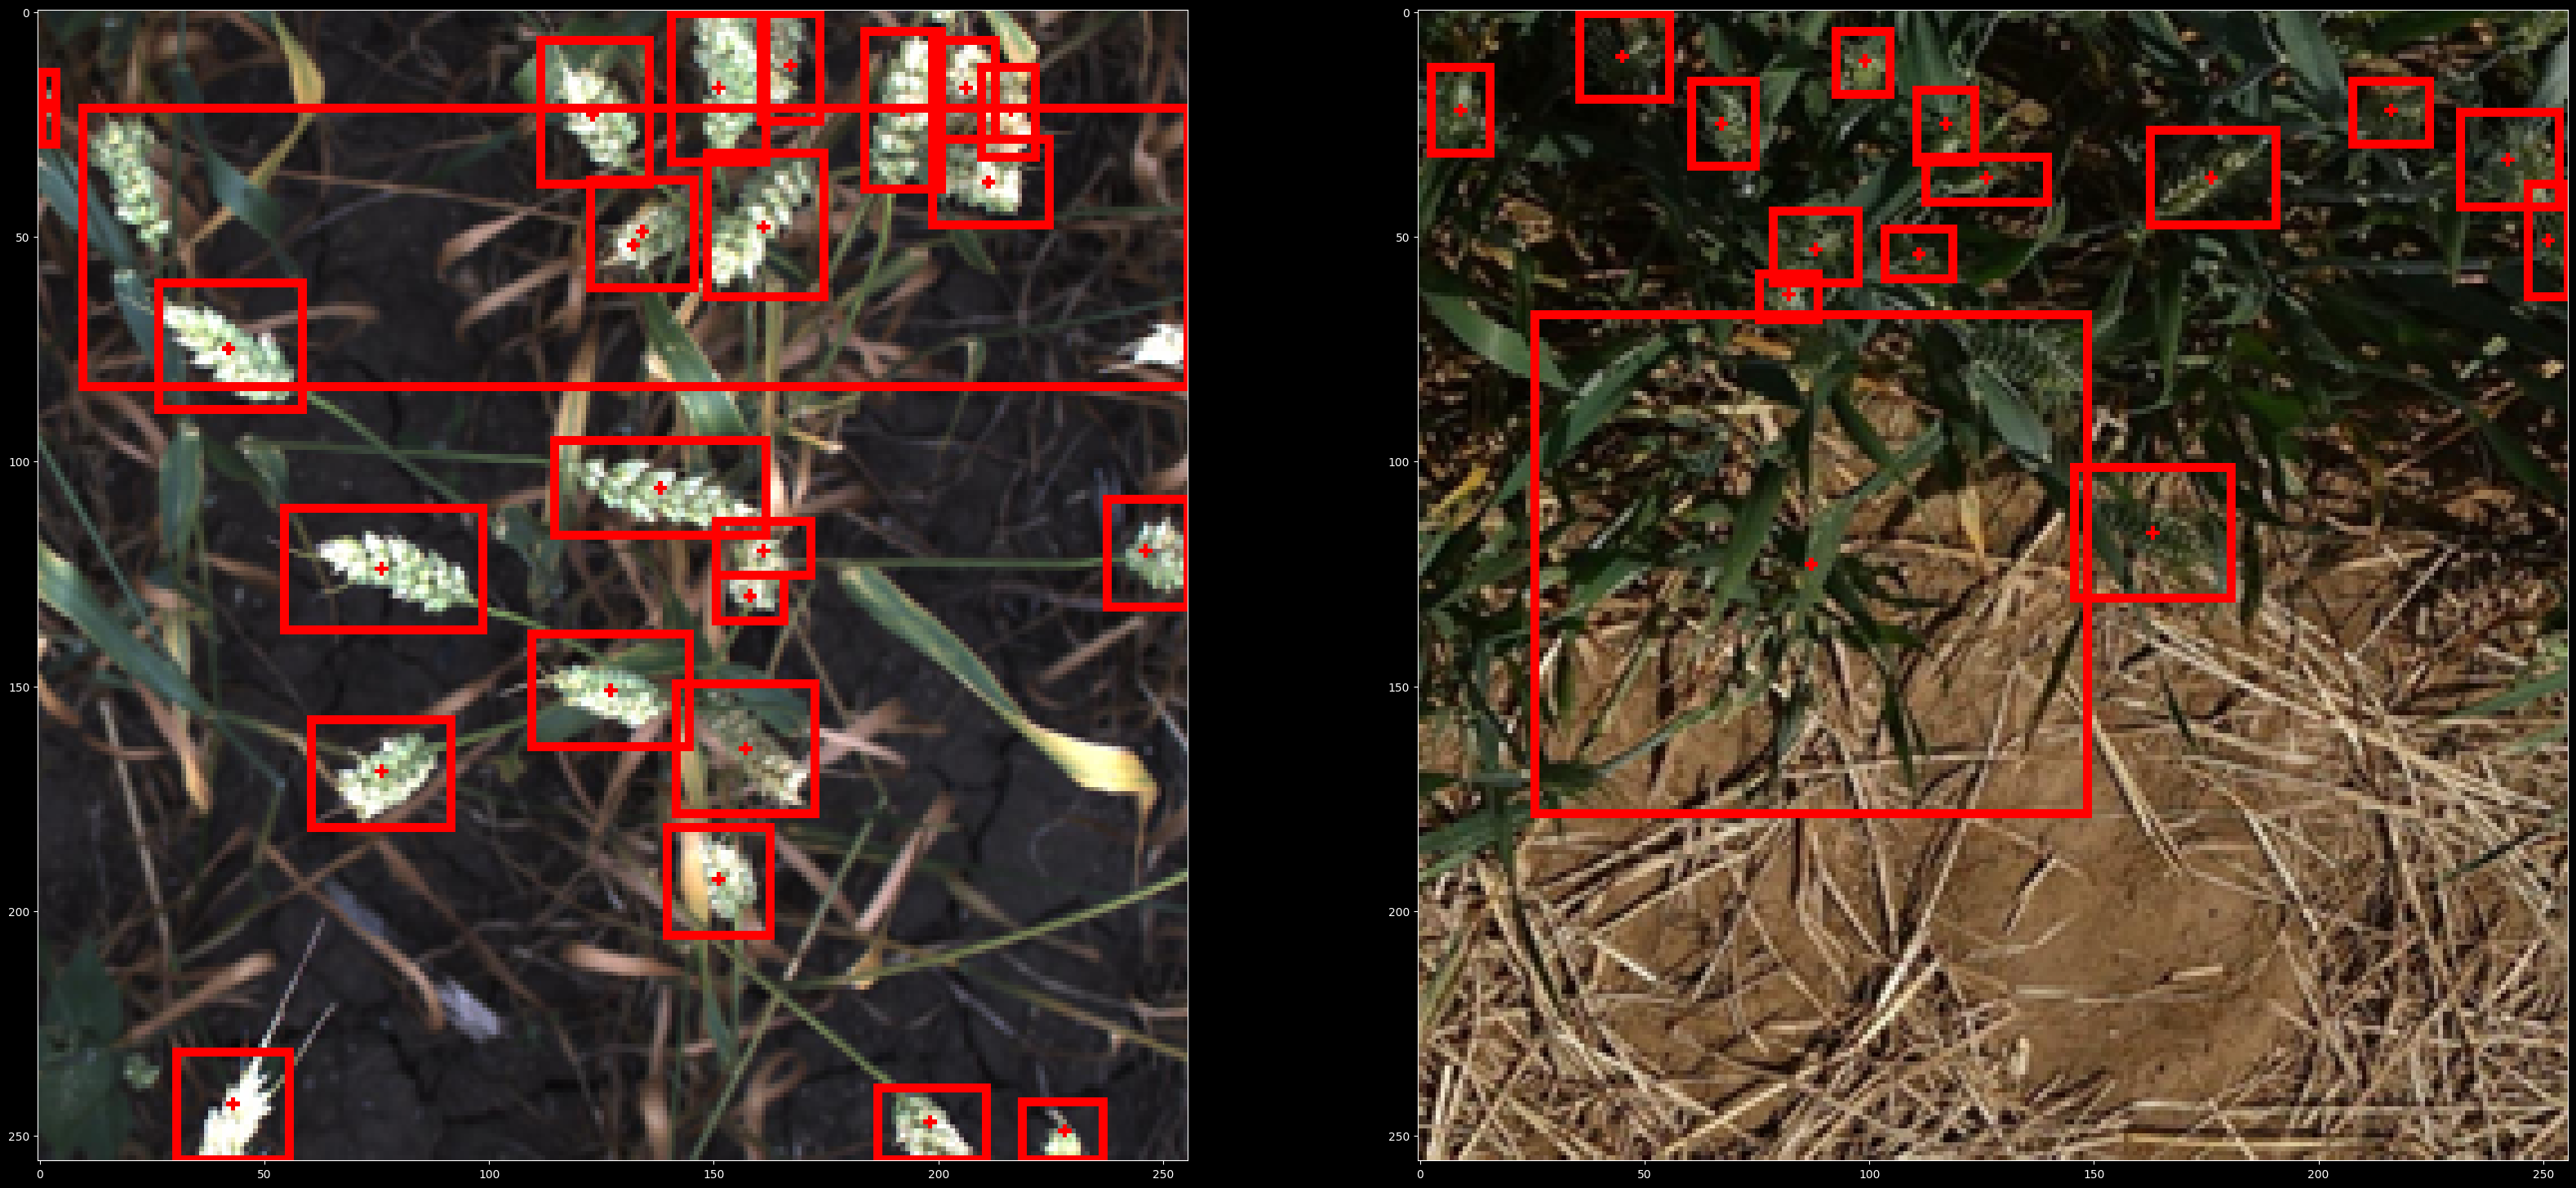

In [64]:
# Lets get some huge bounding boxes image_ids and plot it to see if those are relevant.

# In training data
HUGE_AREA_THRESHOLD = 10000
huge_bbox = []
for i, img_id in enumerate(train_data.index):
    for label in train_labels[img_id]:
        if label[2] * label[3] >= HUGE_AREA_THRESHOLD:    # Area of rect = h * w
            huge_bbox.append(img_id)

print(f"There are {len(huge_bbox)} huge bounding boxes found with the given threshold.")
plot_images_with_bboxes(huge_bbox[:2], train_labels)
huge_bbox.clear()

There are 2 huge bounding boxes found with the given threshold.


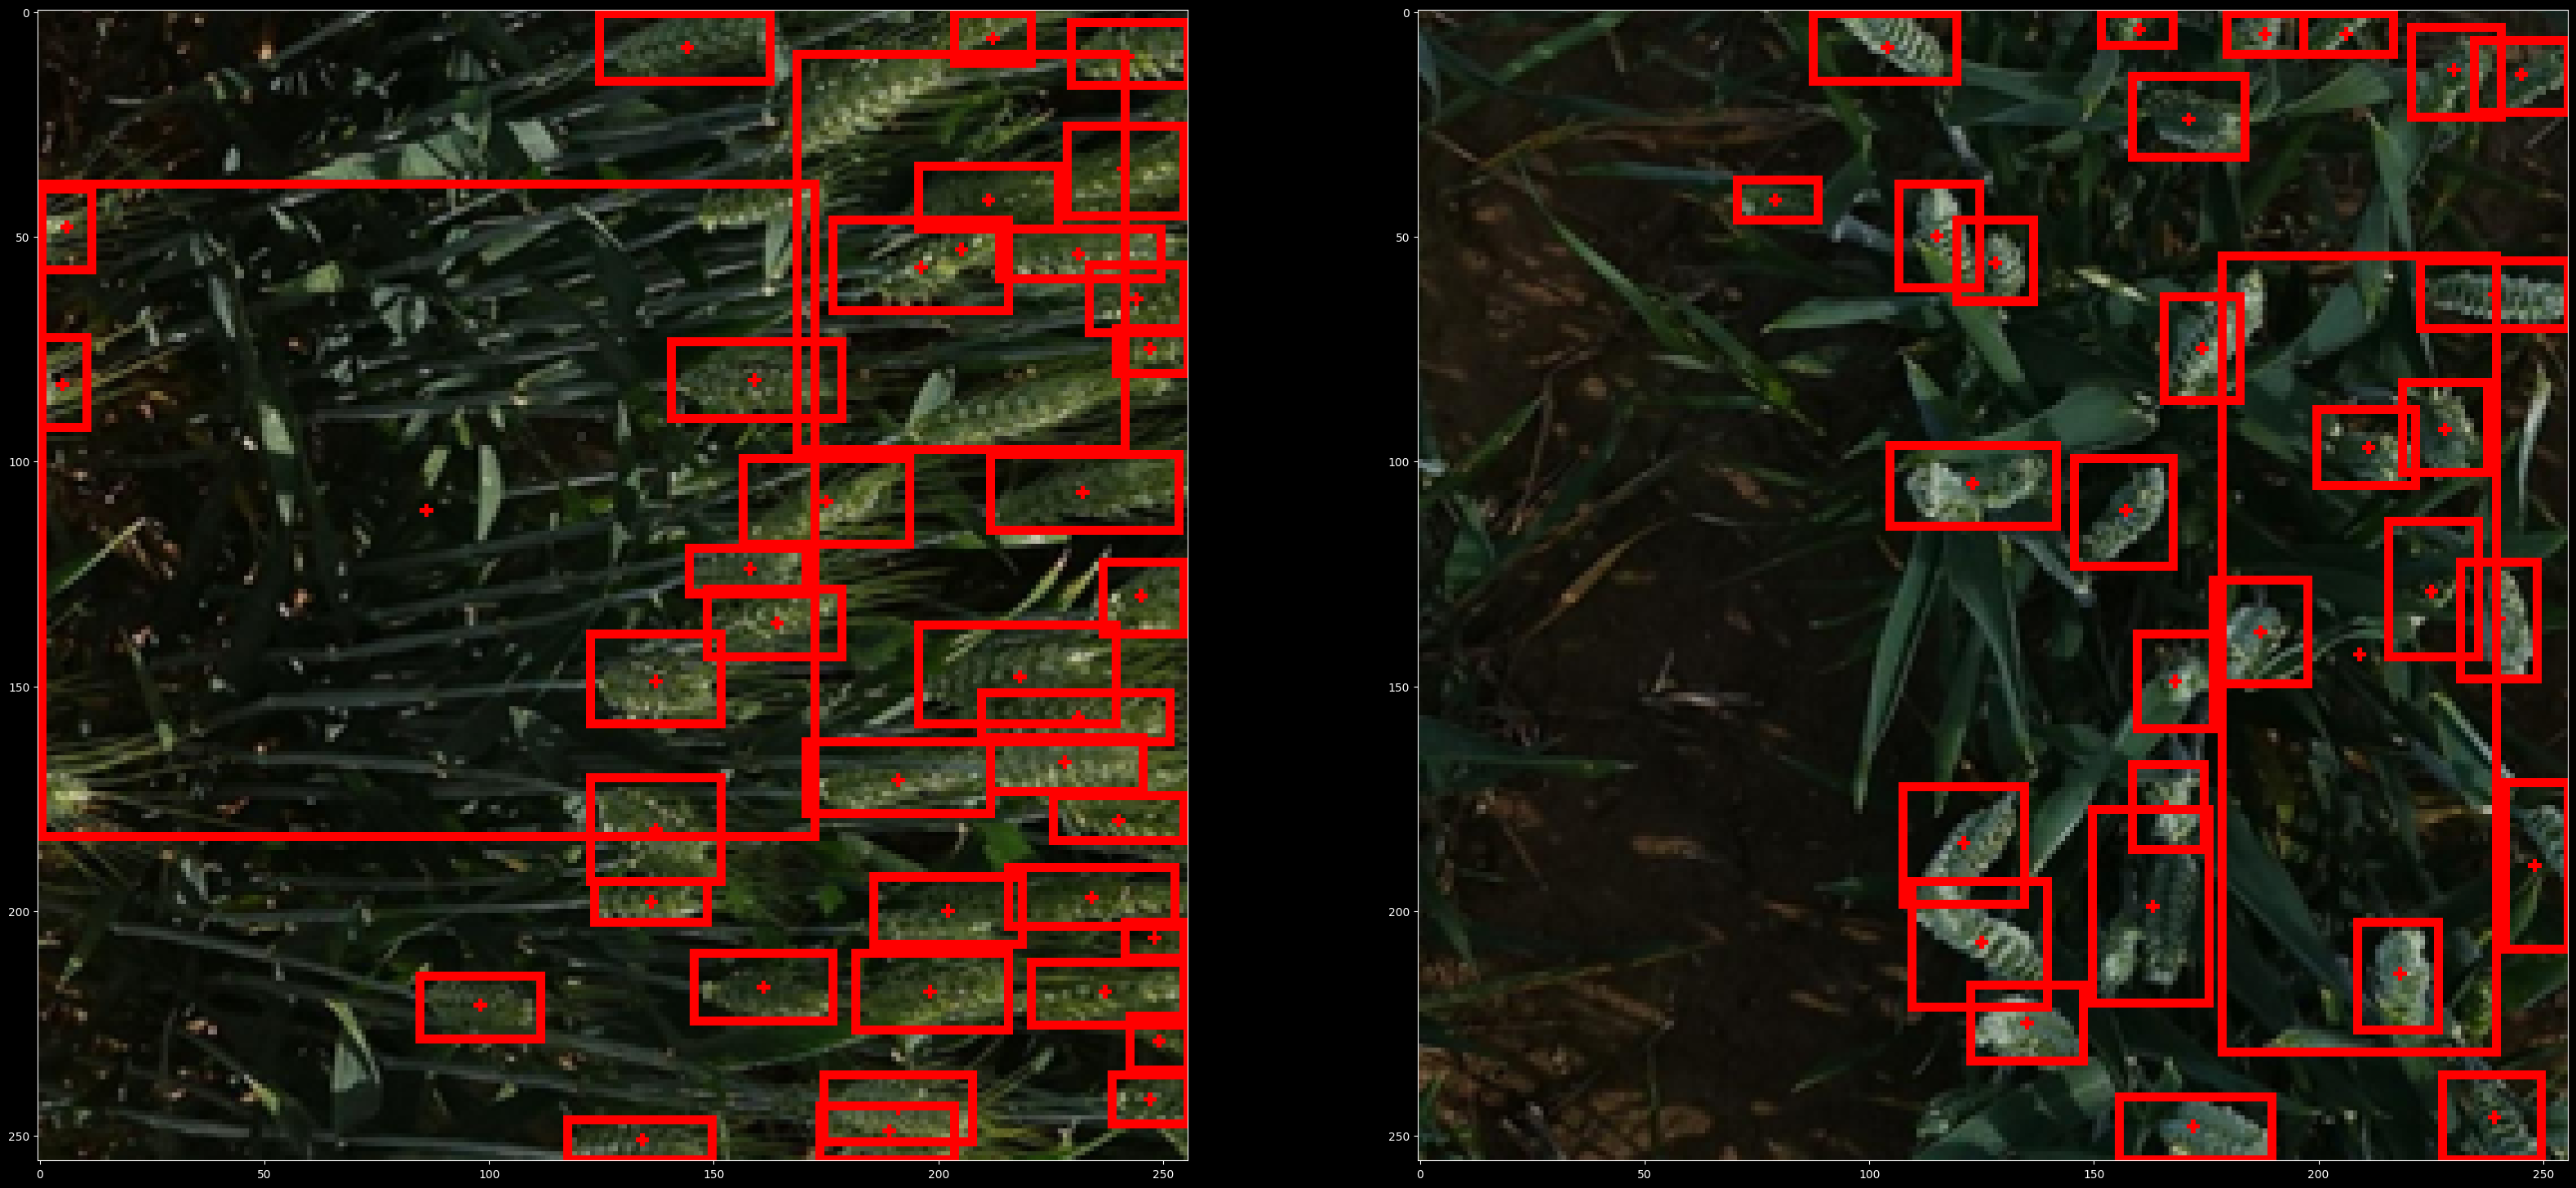

In [65]:
# In validation data
for i, img_id in enumerate(validation_data.index):
    for label in val_labels[img_id]:
        if label[2] * label[3] >= HUGE_AREA_THRESHOLD:    
            huge_bbox.append(img_id)
print(f"There are {len(huge_bbox)} huge bounding boxes found with the given threshold.")
plot_images_with_bboxes(huge_bbox[:2], val_labels)

There are 14 tiny bounding boxes found with the given threshold.


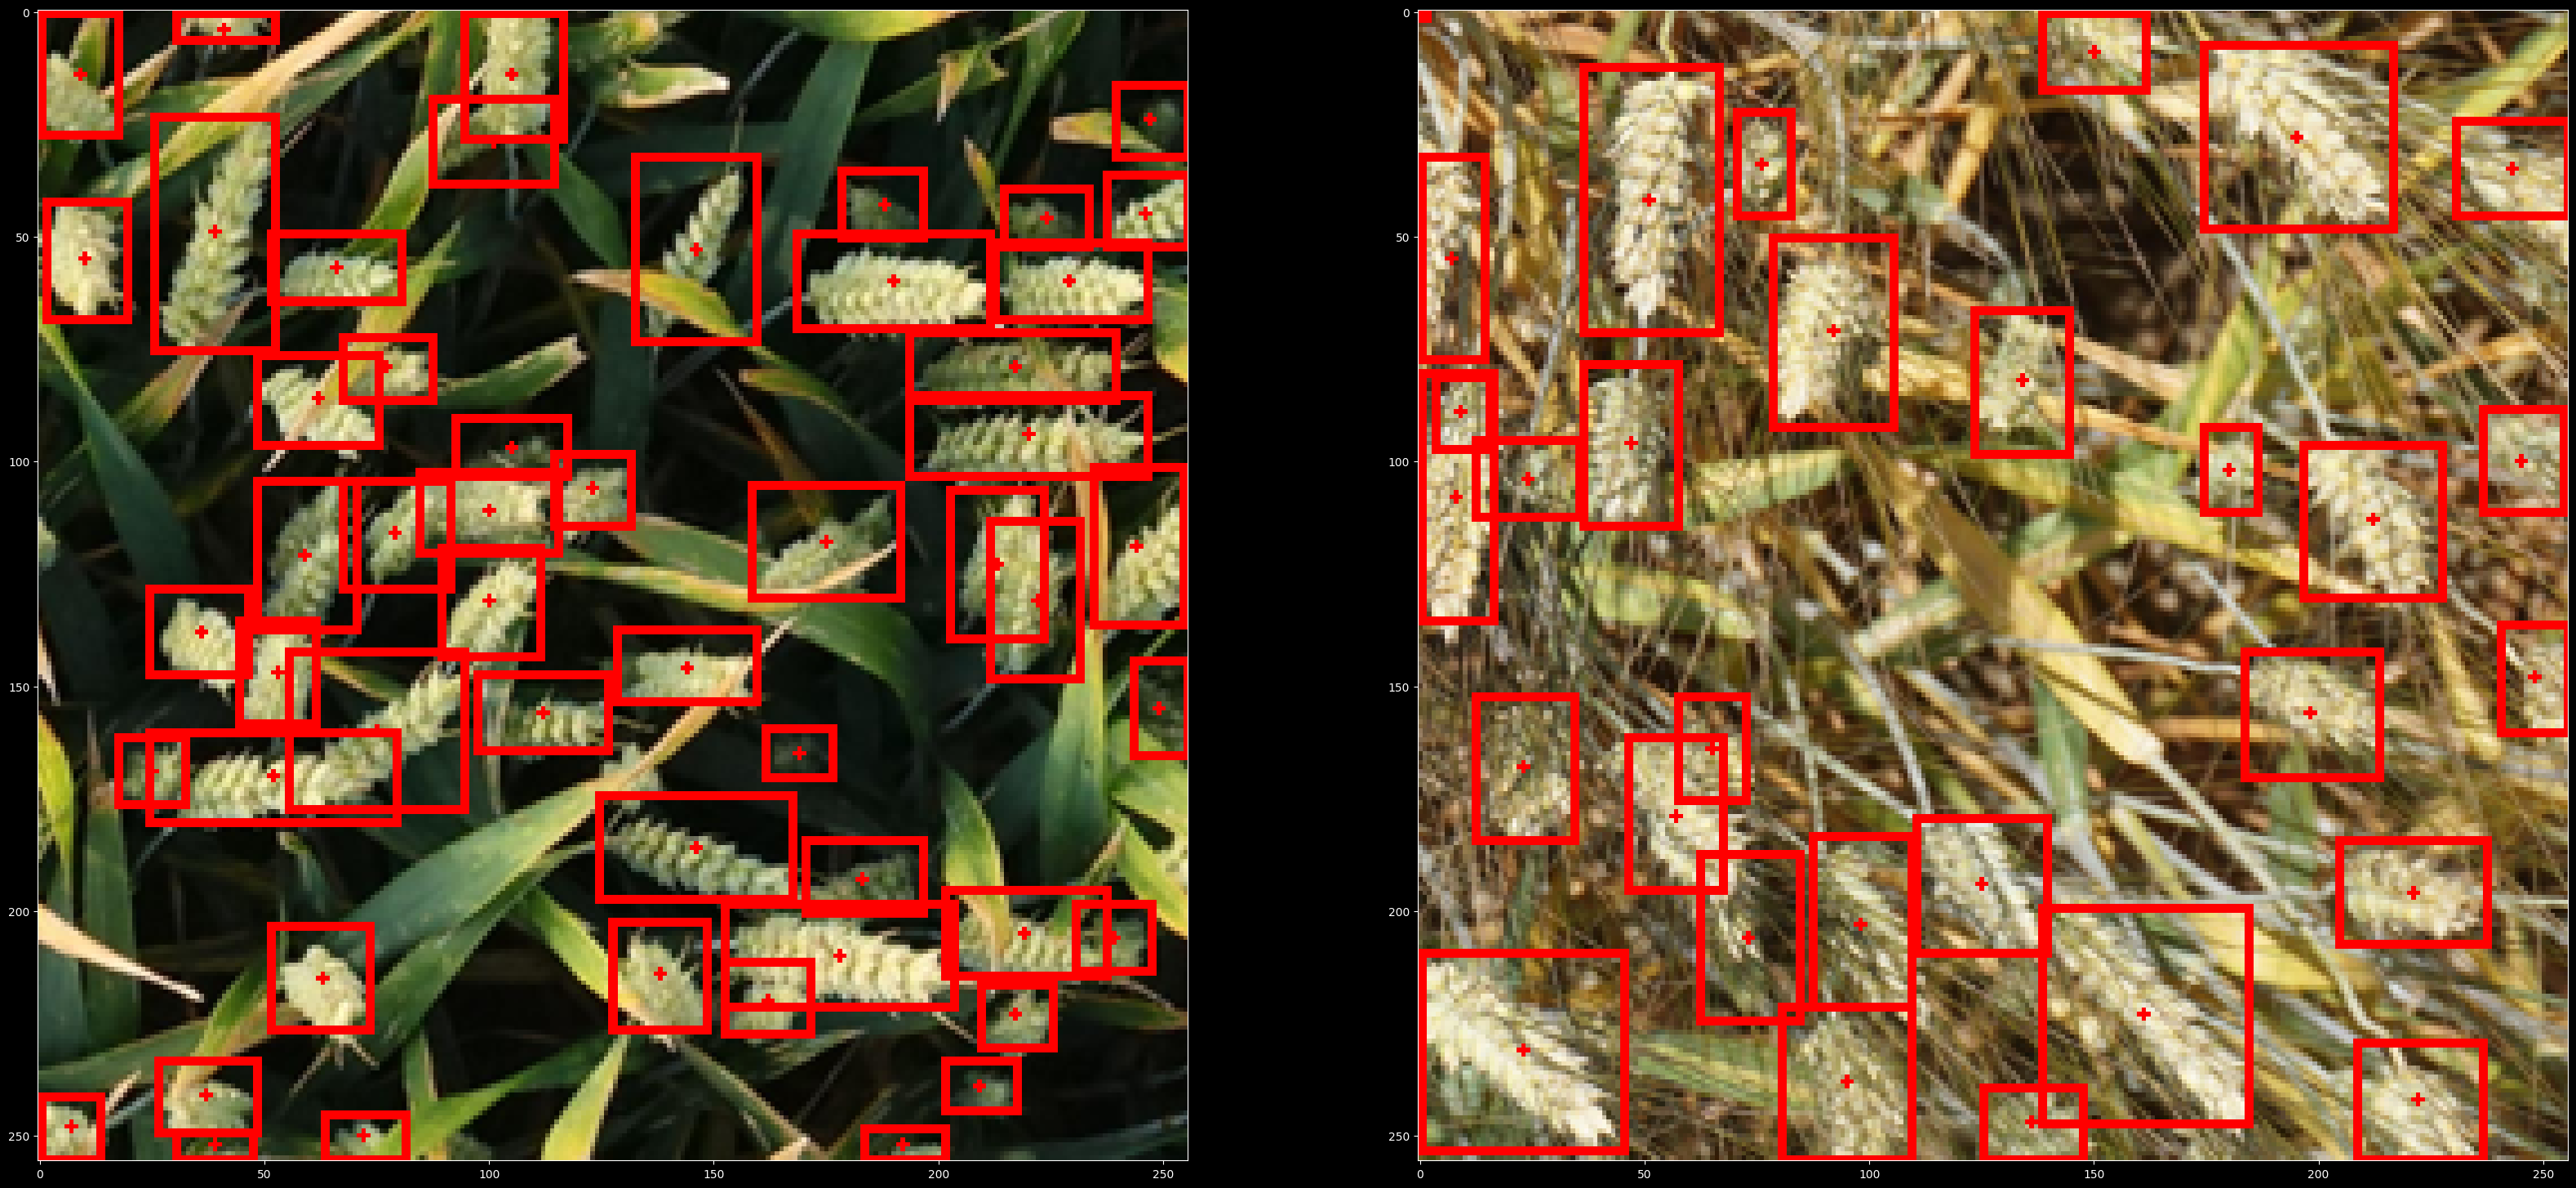

In [66]:
# Lets get some tiny bounding boxes image_ids and plot it to see if those are relevant.

# In training data 
TINY_AREA_THRESHOLD = 5
tiny_bbox = []
for i, img_id in enumerate(train_data.index):
    for label in train_labels[img_id]:
        if label[2] * label[3] <= TINY_AREA_THRESHOLD:    
            tiny_bbox.append(img_id)
print(f"There are {len(tiny_bbox)} tiny bounding boxes found with the given threshold.")
plot_images_with_bboxes(tiny_bbox[:2], train_labels)
tiny_bbox.clear()

There are 3 tiny bounding boxes found with the given threshold.


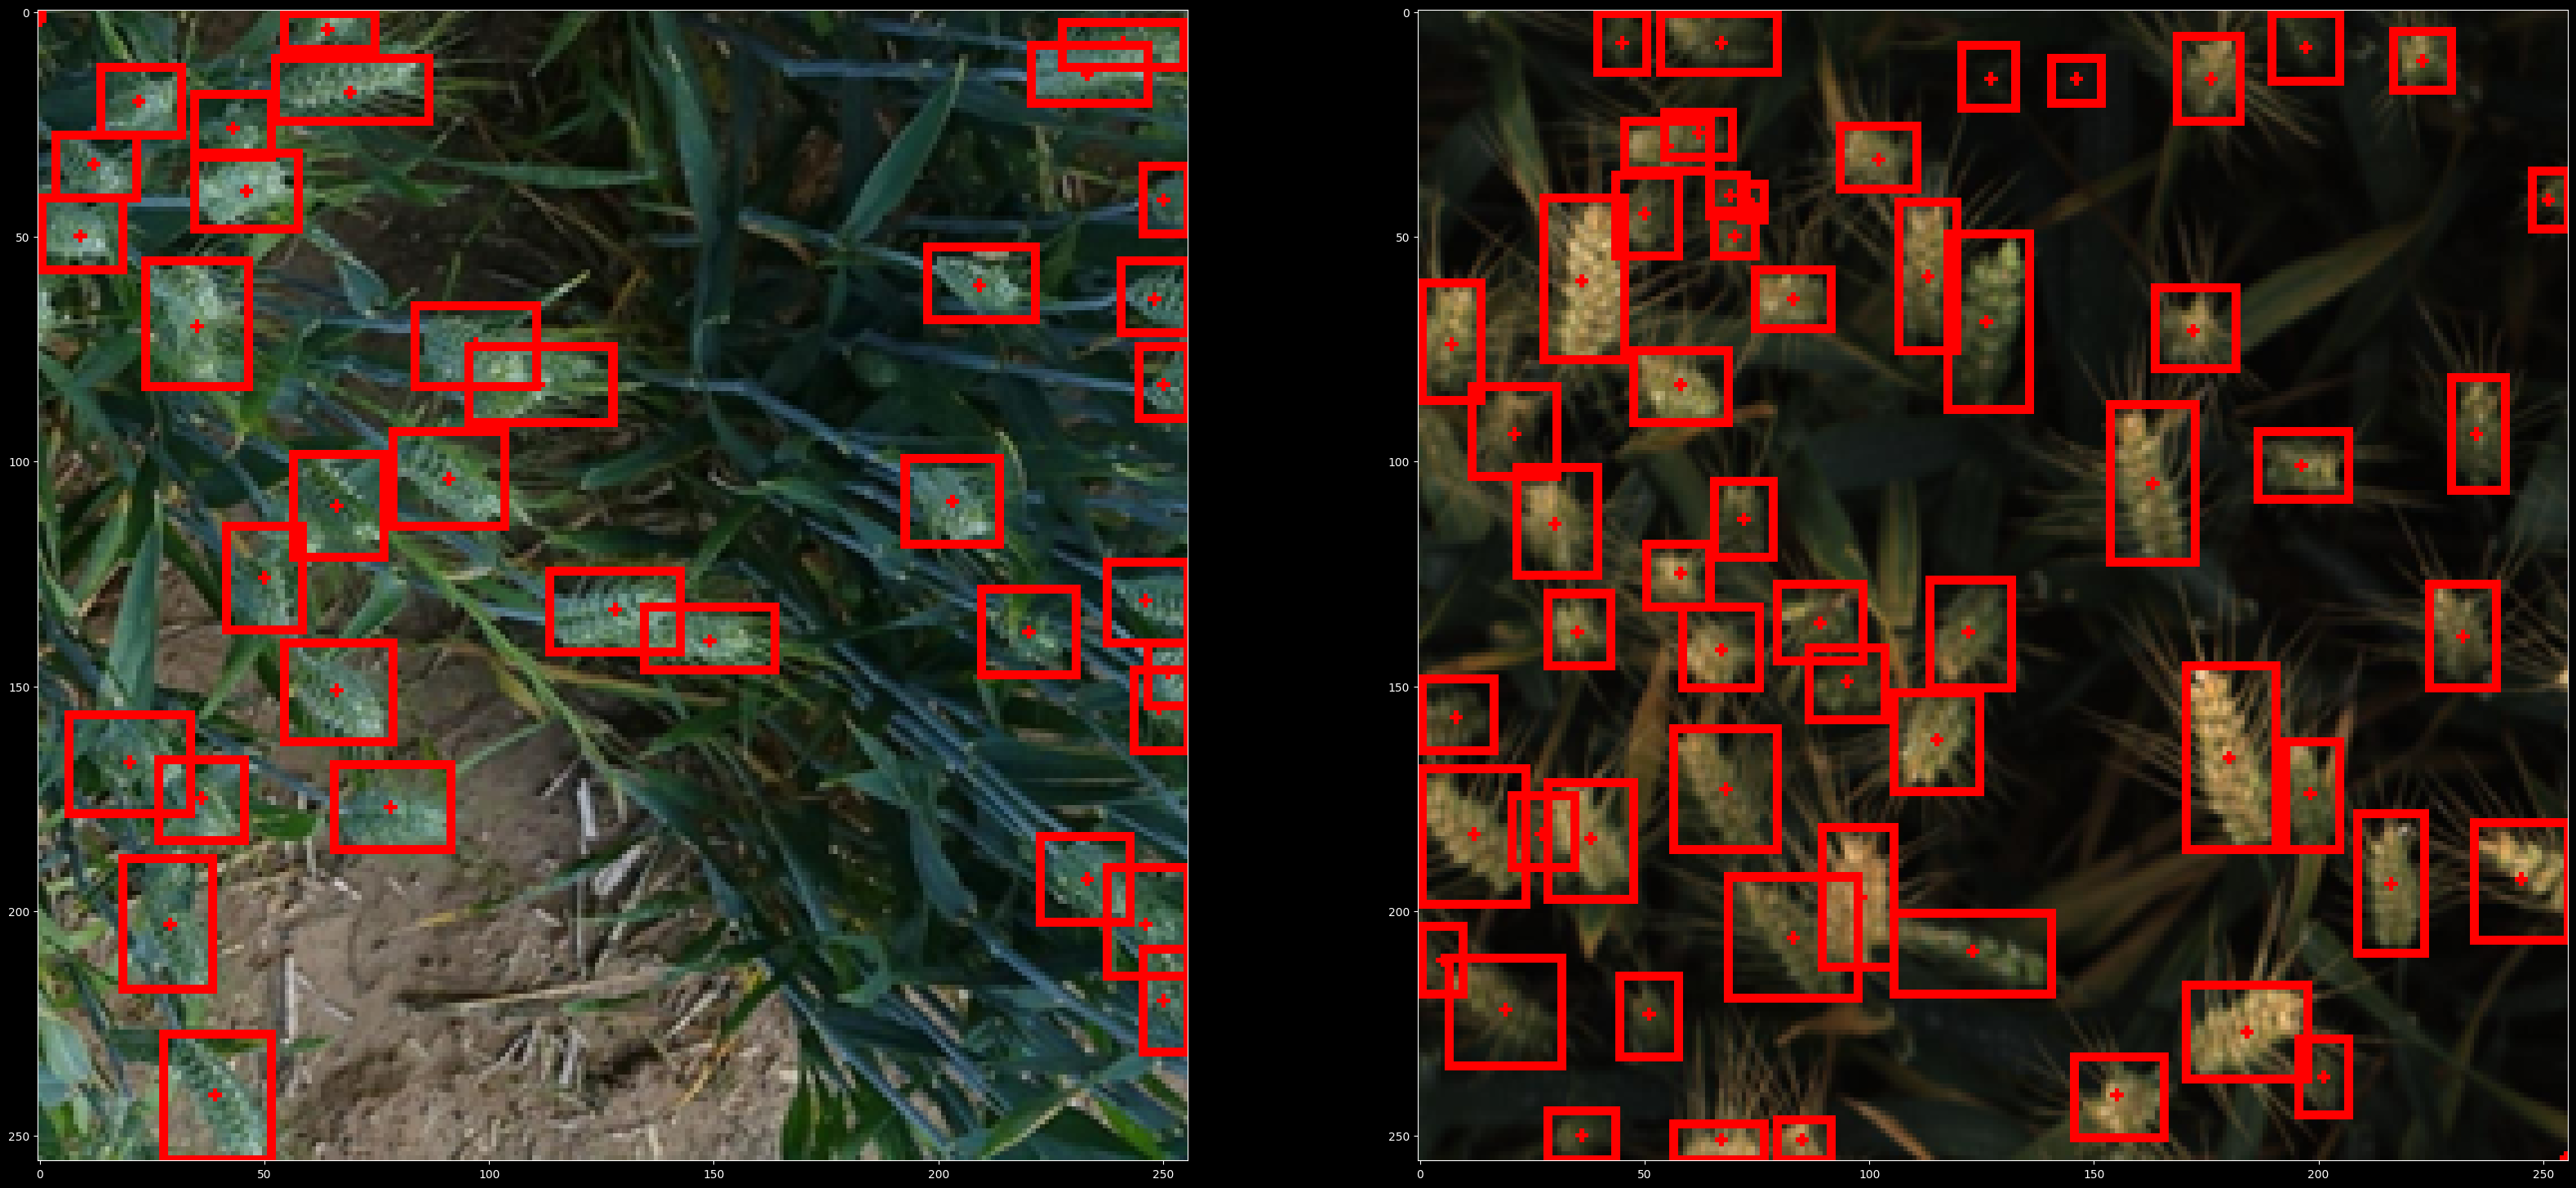

In [67]:
# In validation data 

for i, img_id in enumerate(validation_data.index):
    for label in val_labels[img_id]:
        if label[2] * label[3] <= TINY_AREA_THRESHOLD:    
            tiny_bbox.append(img_id)
print(f"There are {len(tiny_bbox)} tiny bounding boxes found with the given threshold.")
plot_images_with_bboxes(tiny_bbox[:2], val_labels)

- So it is very clear that inorder to get good inference we need our model to focus only on the relevant bounding boxes that are neither too huge nor too tiny.

- This can be done manually by removing the bboxes from the labels dictionary that we have created earlier.

- Both for training and validation data, we will remove the tiny and huge bounding boxes.

- Since pixels dictionary consists of only resized image pixels we will change the labels dictionary only.

- Try changing the area thresholds for both tiny and huge bounding boxes and observe the results

In [68]:
# Function to clean the tiny and huge bboxes present in the labels

def clean_labels(labels_dict, image_ids, T_threshold, H_threshold):
    cleaned_labels = {}
    for img_id in image_ids:
        cleaned_labels[img_id] = []
        for label in labels_dict[img_id]:
            if label[2] * label[3] > 0 and label[2] * label[3] <= T_threshold:  # tiny bbox
                continue
            elif label[2] * label[3] >= H_threshold:                           # huge bbox
                continue
            else:
                cleaned_labels[img_id].append(label.copy())
    return cleaned_labels

In [69]:
# Choose threshold according to your own convinience
train_labels = clean_labels(train_labels, train_data.index, 5, 20000) 
val_labels = clean_labels(val_labels, validation_data.index, 5, 20000)

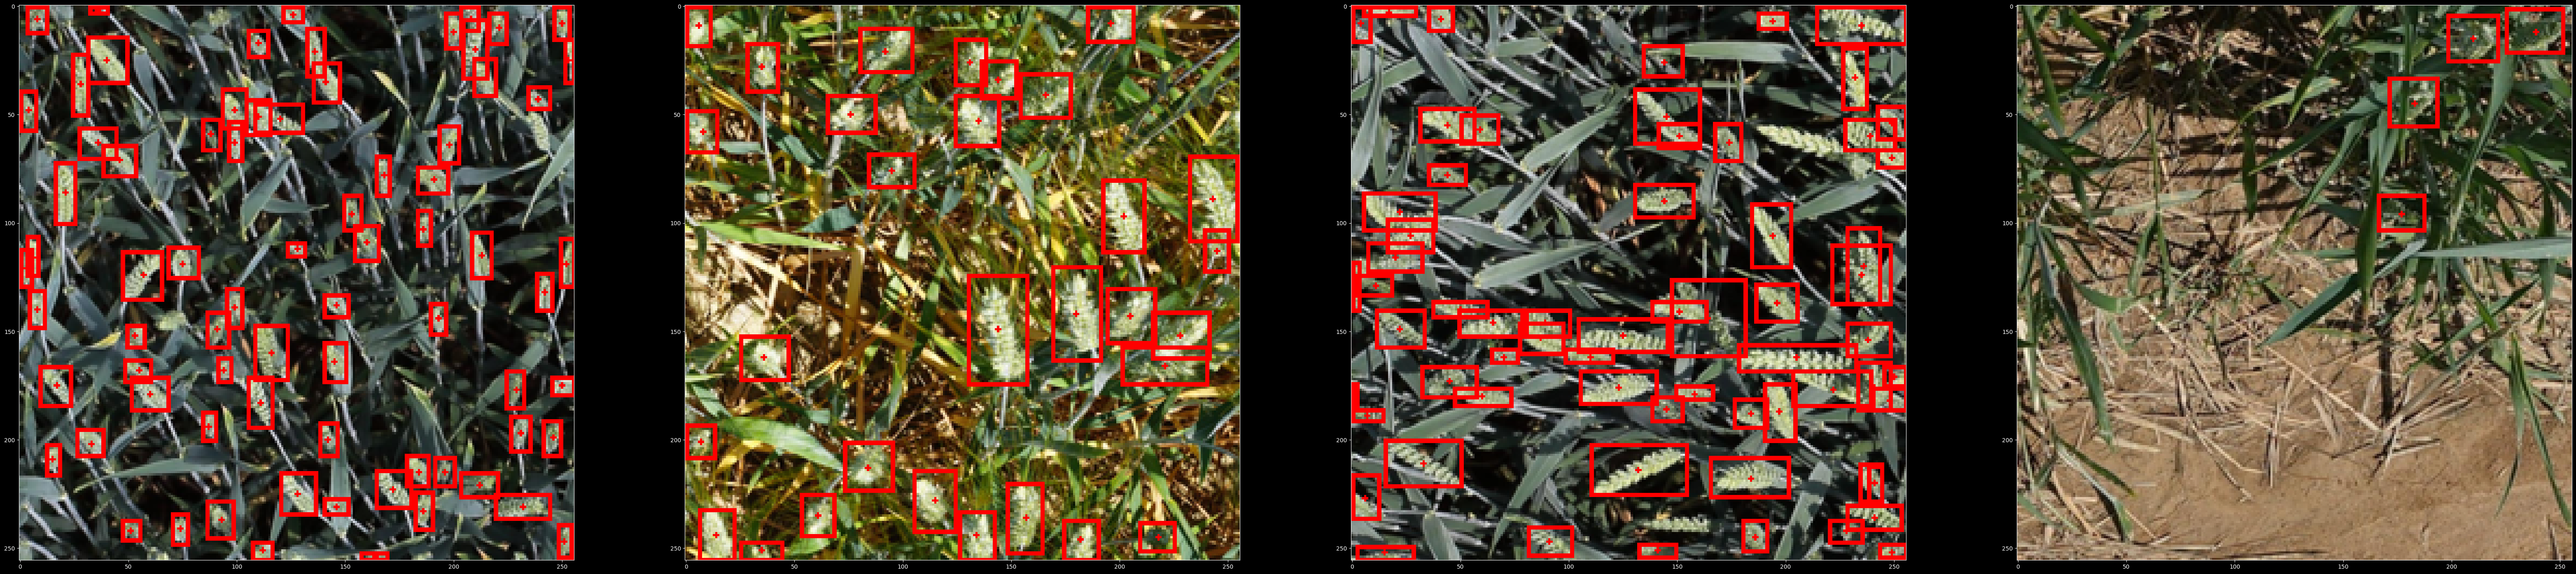

In [71]:
show_images(4)